In [1]:
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

In [2]:
arr1 = [pyemma.coordinates.load(f'../sampling_features/feats_prod/ca_ca_{i:03d}.npy') for i in range(11)]

In [2]:
arr2 = [pyemma.coordinates.load(f'../sampling_features/feats_prod/ca_pairs_{i:03d}.npy') for i in range(11)]

In [35]:
np.shape(arr2[0])

(17501, 224)

In [6]:
combo_all = [np.concatenate([a1, a2], axis=1) for a1, a2 in zip(arr1, arr2)]


In [7]:
np.shape(combo_all[1])

(10001, 6138)

In [3]:
tica_dev = pyemma.coordinates.tica(arr2, dim=3, lag=50)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

In [37]:
np.shape(tica_concatenated)

(130963, 3)

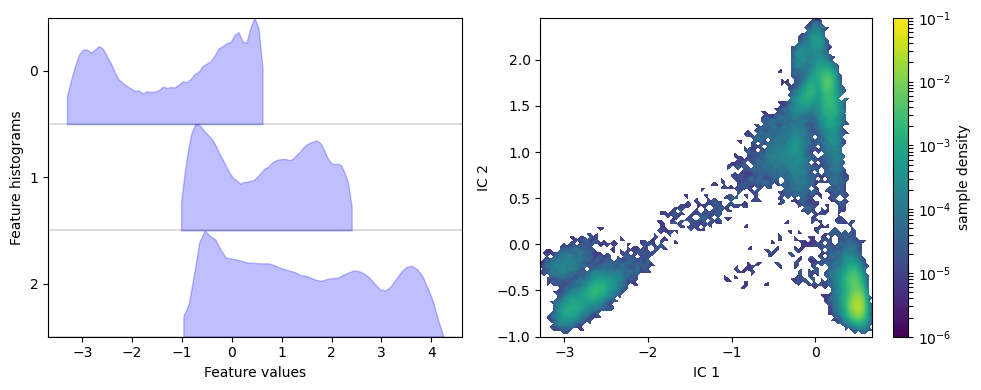

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

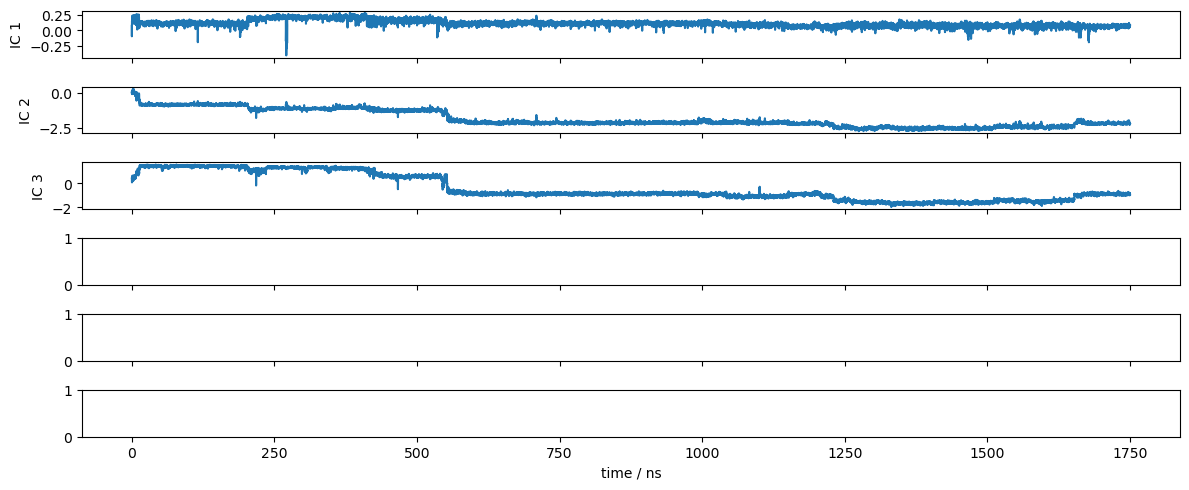

In [16]:
fig, axes = plt.subplots(6, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_out[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_out[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
# plt.savefig('ics_update.png')

In [5]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_out, k=150, max_iter=200, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

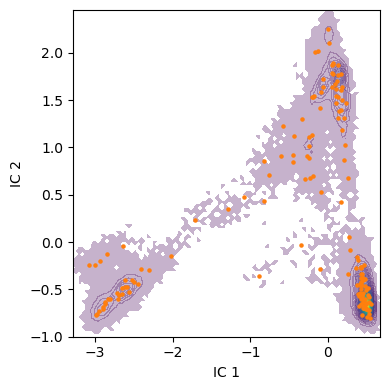

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('cluster_update.png',dpi=300)

In [7]:
its = pyemma.msm.its(cluster.dtrajs, lags=300, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
# plt.savefig('its_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                                 …

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/jaybraun/miniconda3/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/jaybraun/miniconda3/lib/python3.9/multiprocessing/pool.py", line 729, in _terminate_pool
    p.join()
  File "/home/jaybraun/miniconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/jaybraun/miniconda3/lib/python3.9/multiprocessing/popen_fork.py", line 43, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/jaybraun/miniconda3/lib/python3.9/multiprocessing/popen_fork.py", line 27, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=100, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[18]: compute stat. inefficiencies:   0%|                       …

pyemma.msm.estimators.bayesian_msm.BayesianMSM[18]: Sampling MSMs:   0%|                                      …

fraction of states used = 1.00
fraction of counts used = 1.00


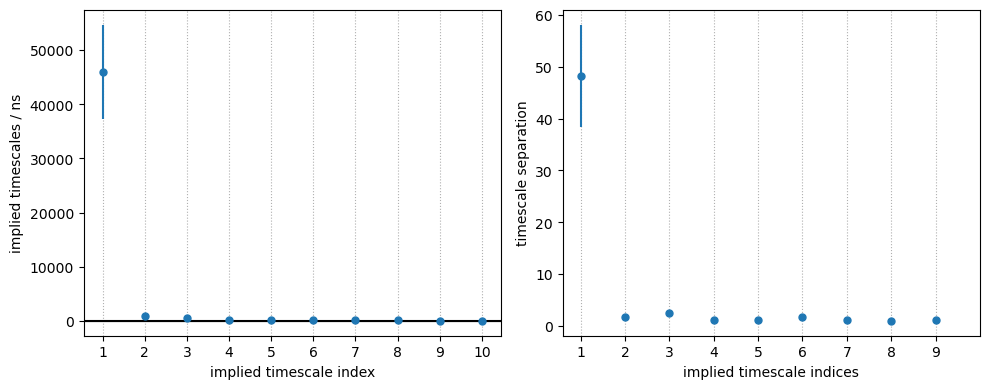

In [9]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('4state_spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                                 …

/home/jaybraun/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 149 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/jaybraun/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 148 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/jaybraun/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 147 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/jaybraun/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 146 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, ca

TypeError: legend() takes 0-2 positional arguments but 3 were given

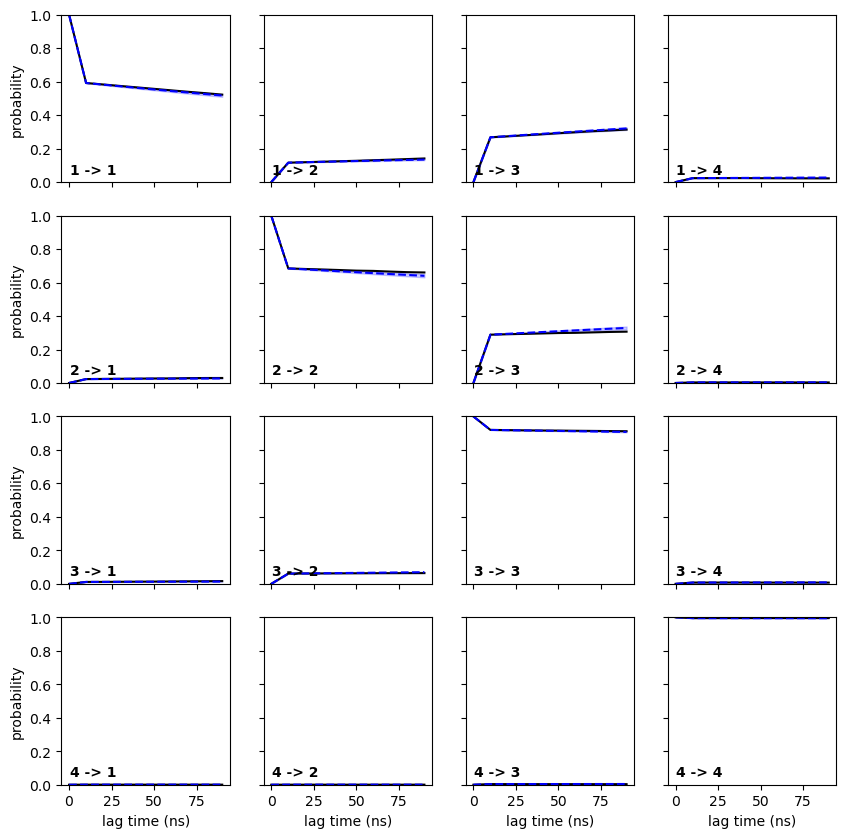

In [10]:
nstates = 4
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('cktets.png',dpi = 300)

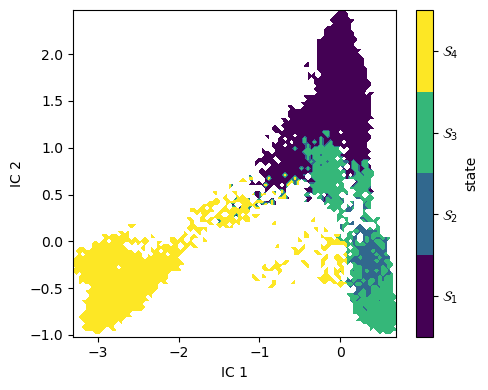

In [11]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

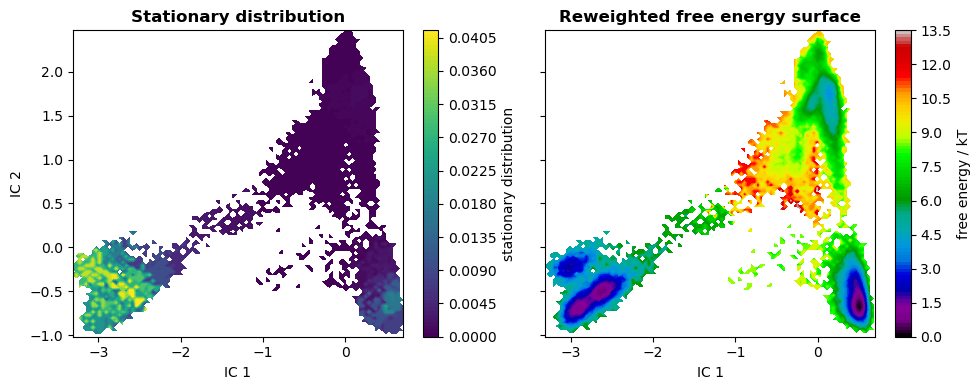

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
# plt.savefig('macro_energy_update.png',dpi=400)

/tmp/ipykernel_4764/3306271696.py:13: RuntimeWarning: divide by zero encountered in log
  fes_kBT = -np.log(hist)


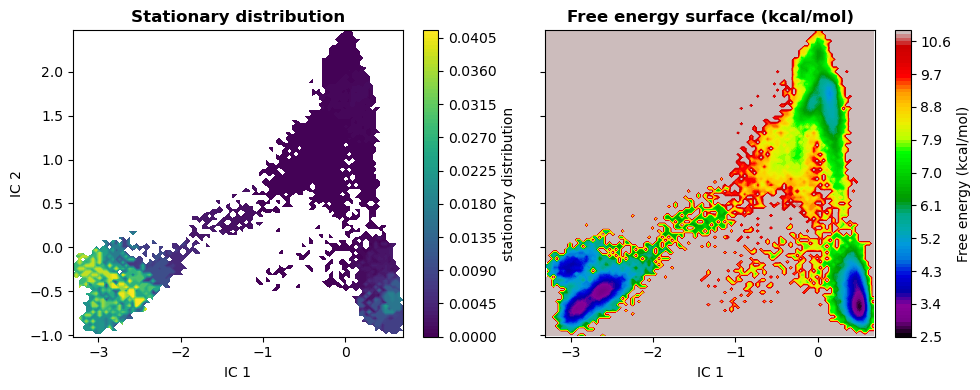

In [13]:
kB = 1.9872036e-3  # kcal/mol·K
T = 310  # You need to provide the temperature in Kelvin

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(
    tica_concatenated[:, 0], tica_concatenated[:, 1], 
    bins=100, weights=np.concatenate(msm.trajectory_weights()))

# Convert histogram to probability
hist /= hist.sum()

# Convert probabilities to free energy in units of kBT
fes_kBT = -np.log(hist)

# Handle infinities
fes_kBT[np.isinf(fes_kBT)] = fes_kBT[~np.isinf(fes_kBT)].max()

# Convert the free energy to kcal/mol
fes_kcal_per_mol = fes_kBT * kB * T

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot stationary distribution
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')

# Plot free energy in kcal/mol
contourf = axes[1].contourf(
    (xedges[:-1] + xedges[1:]) / 2,
    (yedges[:-1] + yedges[1:]) / 2,
    fes_kcal_per_mol.T,  # transpose due to how meshgrid works
    levels=100,  # you can adjust the number of levels or provide explicit levels
    cmap='nipy_spectral'
)
cbar = fig.colorbar(contourf, ax=axes[1])
cbar.set_label('Free energy (kcal/mol)')

for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Free energy surface (kcal/mol)', fontweight='bold')
fig.tight_layout()
# plt.savefig('2state_pmf.png',dpi=400)


In [14]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,11516.97,2428.94,41743.86
2,21215.55,0.00,672.39,43933.98
3,24568.56,10319.05,0.00,43024.43
4,133242.24,126340.09,113776.50,0.00


In [15]:
# Given your code:
A = msm.metastable_sets[0]
B = np.concatenate(msm.metastable_sets[2:])

mfpt_A_to_B_mean = msm.sample_mean('mfpt', B, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', B, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


9.454362755761901e-06
Off-rate (from A to B): 9.45e-06 ± 4.35e-06 1/ns


In [171]:
# Given your code:
A = msm.metastable_sets[2]
B = np.concatenate(msm.metastable_sets[1:])

mfpt_A_to_B_mean = msm.sample_mean('mfpt', B, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', B, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


IndexError: list index out of range

In [188]:
# Given your code:
C = msm.metastable_sets[1]
A = msm.metastable_sets[0]

mfpt_A_to_B_mean = msm.sample_mean('mfpt', C, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', C, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


8.549748188906227e-06
Off-rate (from A to B): 8.55e-06 ± 9.69e-07 1/ns


In [189]:
# Given your code:
C = msm.metastable_sets[1]
A = msm.metastable_sets[0]

mfpt_A_to_B_mean = msm.sample_mean('mfpt', A, C)
mfpt_A_to_B_std = msm.sample_std('mfpt', A, C)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


0.0011758965348062343
Off-rate (from A to B): 1.18e-03 ± 5.10e-05 1/ns


In [16]:
import math

def calculate_deltaG(k_on, k_off, temperature):
    R = 8.314  # J/mol·K
    K = k_on / k_off
    deltaG_joule = -R * temperature * math.log(K)
    
    # Convert from J/mol to kcal/mol
    conversion_factor = 0.000239006
    deltaG_kcal = deltaG_joule * conversion_factor

    print(f"k_on = {k_on:.8f} ns^-1")
    print(f"k_off = {k_off:.8f} ns^-1")
    print(f"Equilibrium constant, K = {K:.2f}")
    print(f"Delta G (J/mol) = {deltaG_joule:.2f} J/mol")
    print(f"Delta G (kcal/mol) = {deltaG_kcal:.2f} kcal/mol")

    return deltaG_kcal

mfpt_bound_to_unbound = 1700  # ns
mfpt_unbound_to_bound = 5.0e7   # ns
temperature = 310               # K

k_on = 1.0 / mfpt_unbound_to_bound
k_off = 1.0 / mfpt_bound_to_unbound
deltaG = calculate_deltaG(k_on, k_off, temperature)


k_on = 0.00000002 ns^-1
k_off = 0.00058824 ns^-1
Equilibrium constant, K = 0.00
Delta G (J/mol) = 26518.64 J/mol
Delta G (kcal/mol) = 6.34 kcal/mol
